# Sutton 1988 Experiment Replication

### RandomWalk() creates the Random Walk sequences used for the experiment

In [1]:

# Used to Generate Random Walk game
import matplotlib.pyplot as plt 
import numpy as np
import math

class RandomWalk(object):

    def __init__(self):
        self.position = 2
        self.letter_position = chr(self.position+66)
        self.value = 0
        self.prob = 0.5
        
        self.GAME_END = "PLAY"
        self.actions = ['left','right']
        
        self.game_state = [] 
        self.game_state.append([0,0,1,0,0])
        
        self.action_list = []
        self.action_list.append("start")
        
        self.numeric_sequence_list = []
        self.numeric_sequence_list.append(self.position)
        
        self.sequence_list = []
        self.sequence_list.append(self.letter_position)
        
        self.rewards_list = []
        self.reward = 0
        
        self.training_sets = []
        pass
    
    # Generates random walk action  
    def generate_action(self):
        return np.random.choice(self.actions,p=[self.prob,1-self.prob])

    # Applies random walk action and updates game functions
    def take_action(self):
        self.action = RandomWalk.generate_action(self)
        self.action_list.append(self.action)
        
        if self.action == 'left':
            self.position = self.position-1
            self.letter_position = chr(self.position+66)
            self.sequence_list.append(self.letter_position)
            self.numeric_sequence_list.append(self.position)
        
        elif self.action == 'right':
            self.position = self.position+1
            self.letter_position = chr(self.position+66)
            self.sequence_list.append(self.letter_position)
            self.numeric_sequence_list.append(self.position)
           
    # produces unit vector for respective state  
    def value_state(self):
        self.state = []
        for i in range(5):
            if i == self.position:
                self.state.append(1)
            
            else:
                self.state.append(0)
                
    # updates game state        
    def update_state(self):
        RandomWalk.game_state(self)
        RandomWalk.value_state(self)
        
        if self.letter_position == 'A':
            return 0     
        
        elif self.letter_position == 'G':
            return 1     
        
        else:
            return self.state    
           
    # evaluates games state    
    def game_state(self):
        if self.position < 0:
            self.GAME_END = "WORSE_END"
            self.rewards_list.append(0)
            self.reward = 0
            
        elif self.position >4:
            self.GAME_END = "OPTIMAL_END"
            self.rewards_list.append(1)
            self.reward = 1
            
        else:
            self.rewards_list.append(0)
            self.reward = 0
    
    
    def play_game(self):
        while self.GAME_END == 'PLAY':
            RandomWalk.take_action(self)
            self.game_state.append(RandomWalk.update_state(self))
        return self.game_state    #,self.sequence_list,self.action_list,self.numeric_sequence_list
    

### DataBuild() builds the dataset for our experimentation

In [2]:
class DataBuild(object):
    
    def __init__(self):
        self.agent = RandomWalk()
        pass
    
    
    def reset_agent(self):
        self.agent = RandomWalk()
        
    #creates a (100x10xn) training dataset 
    def create_training_sets(self):
        training_sets = []
        for i in range(100):
            run_set = []
            for j in range(10):
                self.agent = RandomWalk()
                run_set.append(self.agent.play_game())
            training_sets.append(run_set)
        return training_sets
    
    #creates (100x5) weights list
    def create_weights(self):
        weights = []
        for i in range(100):
            weights.append([0.1,0.2,0.3,0.4,0.5])
        return weights


### Functions used to calculate our weighted updates

In [3]:
# Used to calculate the sum of all past values for delta_weights
def delta_sum(s,r,l):
        gradient_w = np.array([0,0,0,0,0])

        for i in range(len(s)):
            past_discount_value = np.array([(l**(r-i-1))])*s[i]
            gradient_w = np.add(gradient_w,past_discount_value)
        return gradient_w

# Sums list of weights
def sum_weights(d_list):
        data = d_list.copy()

        summati = [0,0,0,0,0]
    
        for i in range(len(data)):
            summati = np.add(np.array(summati),np.array(data[i]))

        return summati

#Used to calculated delta_w
def calc_delta_(set_weight_,sequence_i,lam,alpha):
        run = 1
        sequence_run = []
        delta_weights_list = []
        set_weight_ = np.array(set_weight_)
        
        for state in range(len(sequence_i)-1):
            sequence_run.append(sequence_i[state])
            
            #used to calculate difference of temporally successive steps
            if state == len(sequence_i)-2:
                parts = alpha*(sequence_i[state+1]-set_weight_.dot(np.array(sequence_i[state]).T))
                
            else:
                parts = alpha*(set_weight_.dot(np.array(sequence_i[state+1]).T)-set_weight_.dot(np.array(sequence_i[state]).T))
             
            #calculates the discounted sum of all past predictions
            second_part = delta_sum(sequence_run,run,lam)
             
            delta_weights = parts*second_part 
            run += 1
        
            delta_weights_list.append(delta_weights) 
        
        delta = sum_weights(delta_weights_list)
        return delta

## Generate Datasets

In [4]:
dataset = DataBuild().create_training_sets()
print('Dataset Shape: ',np.array(dataset).shape)
print()

weights = DataBuild().create_weights()
print('Weights Shape: ',np.array(weights).shape)
print()

Dataset Shape:  (100, 10)

Weights Shape:  (100, 5)



C:\Users\Jan Ramos\AppData\Local\Temp\ipykernel_18996\2059140979.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print('Dataset Shape: ',np.array(dataset).shape)


## Figure 3 - Experiment

In [5]:
#used to generate Figure 3

RMS = []
for lam in [0,0.1,0.3,0.5,0.7,0.9,1]:
    dataset_error = []
     
    for training_set in dataset:
        weights =  [0.1,0.2,0.3,0.4,0.5] #resets weights
        while True:
            output=[]
            for sequence in training_set:
                 output.append(calc_delta_(weights,sequence,lam,0.01)) #calc delta
            current_delta = sum_weights(output) #accumulate delta
            
            difference = np.linalg.norm(current_delta)
            
            if difference <  0.001: 
                break
            else:
                weights = np.add(weights,current_delta) #update step
                
                
        error = np.sqrt(((np.array(weights)-np.array([1/6,2/6,3/6,4/6,5/6]))**2).mean())
        dataset_error.append(error)
  
    RMS.append(np.mean(dataset_error))

## Figure 3 - Plot

Text(0.5, 1.0, 'Figure 3')

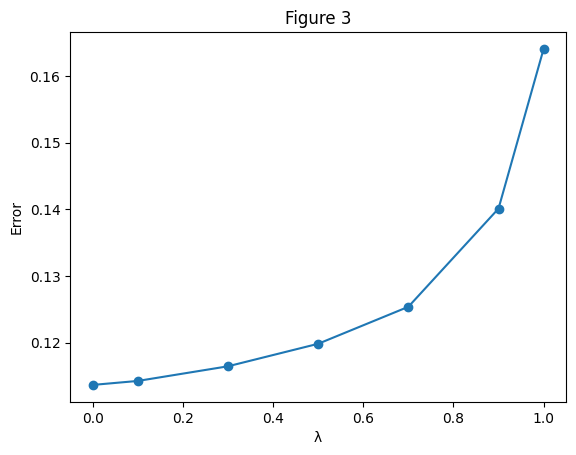

In [6]:
plt.plot([0,0.1,0.3,0.5,0.7,0.9,1],RMS,marker='o')
plt.xlabel('λ')
plt.ylabel('Error')
plt.title('Figure 3')

## Figure 4 - Experiment

In [7]:
#used to generate Figure 4

alphas = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
alpha_RMS = []
for lam in [0,0.3,0.8,1]:
     
    RMS = []
    for alpha in alphas:
        training_set_error = []
        
        for training_set in dataset:
            weights = np.array([0.5,0.5,0.5,0.5,0.5]) #resets weights
            for sequence in training_set:
                weights = np.add(weights,calc_delta_(weights,sequence,lam,alpha)) #calc delta and update step
            error = np.sqrt(((np.array(weights)-np.array([1/6,2/6,3/6,4/6,5/6]))**2).mean())
            training_set_error.append(error)
        RMS.append(np.mean(training_set_error))
    alpha_RMS.append(RMS)

## Figure 4 - Plot

Text(0, 0.5, 'Error')

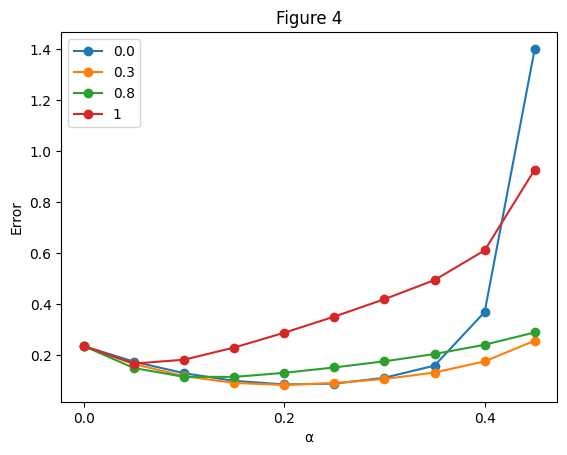

In [8]:
plt.figure()
plt.xticks(np.arange(0, 1, step=0.2))
plt.plot(alphas[:10],alpha_RMS[0][:10],marker='o')
plt.plot(alphas[:10],alpha_RMS[1][:10],marker='o')
plt.plot(alphas[:10],alpha_RMS[2][:10],marker='o')
plt.plot(alphas[:10],alpha_RMS[3][:10],marker='o')
plt.legend([0.0,0.3,0.8,1])
plt.title('Figure 4')
plt.xlabel('α')
plt.ylabel('Error')

## Figure 5 - Experiment

In [9]:
#used to generate Figure 5

alphas = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
alpha_RMS = []
for lam in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
     
    RMS = []
    
    for alpha in alphas:
        training_set_error = []
        
        for training_set in dataset:
            weights = np.array([0.5,0.5,0.5,0.5,0.5]) #resets weights
            for sequence in training_set:
                weights = np.add(weights,calc_delta_(weights,sequence,lam,alpha)) #calc delta and update step
            error = np.sqrt(((np.array(weights)-np.array([1/6,2/6,3/6,4/6,5/6]))**2).mean())
            training_set_error.append(error)
        RMS.append(np.mean(training_set_error))
    alpha_RMS.append(RMS)



## Figure 5 - Plot

Lambda: 0 | Optimal Weight: 0.2 | Minimum: 0.08553610808083537
Lambda: 0.1 | Optimal Weight: 0.2 | Minimum: 0.08360598864504754
Lambda: 0.2 | Optimal Weight: 0.2 | Minimum: 0.08288042057217464
Lambda: 0.3 | Optimal Weight: 0.2 | Minimum: 0.0836019851084696
Lambda: 0.4 | Optimal Weight: 0.2 | Minimum: 0.0861276185278151
Lambda: 0.5 | Optimal Weight: 0.15 | Minimum: 0.0906801837871021
Lambda: 0.6 | Optimal Weight: 0.15 | Minimum: 0.0938325779414368
Lambda: 0.7 | Optimal Weight: 0.15 | Minimum: 0.10109018705463785
Lambda: 0.8 | Optimal Weight: 0.15 | Minimum: 0.11501491188072789
Lambda: 0.9 | Optimal Weight: 0.1 | Minimum: 0.1298586439781119
Lambda: 1 | Optimal Weight: 0.05 | Minimum: 0.16731579604848984


Text(0, 0.5, 'Error')

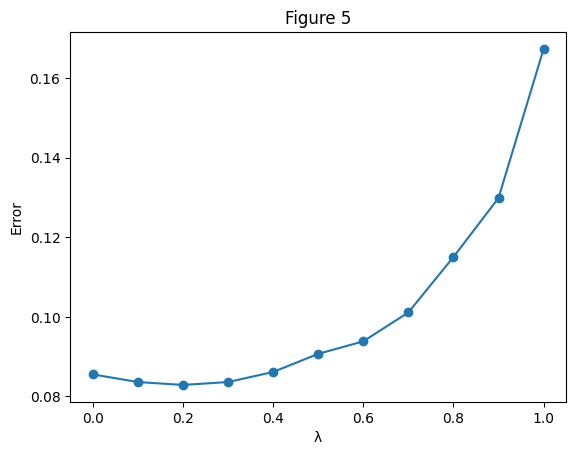

In [10]:
optimal_weights = []
alpha_list = []
lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
alphas = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
i=0
for lambda_ in alpha_RMS:
    index = np.argmin(lambda_)
    optimal_weights.append(alphas[index])
    print('Lambda: {} | Optimal Weight: {} | Minimum: {}'.format(lams[i],alphas[index],np.min(lambda_)))
    alpha_list.append(np.min(lambda_))
    i+=1
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],alpha_list,marker = 'o')
plt.title('Figure 5')
plt.xlabel('λ')
plt.ylabel('Error')